# The Insulin Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [48]:
# install Pint if necessary
"""
try:
    import pint
except ImportError:
    !pip install pint
"""

'\ntry:\n    import pint\nexcept ImportError:\n    !pip install pint\n'

In [49]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/modsim.py')

In [50]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

The following cells download and read the data.

In [51]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/data/glucose_insulin.csv')

In [52]:
data = pandas.read_csv('glucose_insulin.csv', index_col='time');

In Chapter 17 I present the glucose minimal model; in Chapter 18 we implemented it using `run_simulation` and `run_solve_ivp`.
In this case study, we'll implement the other half of the Minimal Model, which describes the concentration of insulin.

In the insulin minimal model, the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

where $G(t)$ is the concentration of glucose at time $t$, and
$k$, $\gamma$, and $G_T$ are positive-valued parameters:

* $k$ controls the rate of insulin disappearance.

* $G_T$ determines the glucose threshold: when $G(t)$ exceeds this threshold, it causes insulin to appear; when $G(t)$ is below this threshold, it causes insulin to disappear.

* $\gamma$ controls how quickly insulin appears or disappears when the concentration of glucose is elevated or depressed.
 
Notice that this equation depends on time, $t$, since the initial injection.  It has the effect of increasing glucose sensitivity over time.  If you are familiar with control systems, the effect of this term is similar to the integral term in a [PID controller](https://en.wikipedia.org/wiki/PID_controller).

In addition to the three parameters in the equation, we will also consider the initial concentration of insulin, $I_0$, to be a free parameter; that is, we will choose the value of $I_0$, and the other parameters, that best fit the data.

**Exercise:**  Write a version of `make_system` that takes the parameters of the model (`I0`, `k`, `gamma`, and `G_T`) as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_solve_ivp`.

Use it to make a `System` object with the following parameters:

In [53]:
I0 = 360   
k = 0.25
gamma = 0.004
G_T = 80

params = I0, k, gamma, G_T

In [54]:
# Solution goes here
def make_system(params, data):
    I0, k, gamma, G_T = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    G = modsim.interpolate(data.glucose)
    
    init = modsim.State(I=I0) # only those that changes in time
    
    return modsim.System(
        init=init, params=params,
        G=G,
        t_0=t_0, t_end=t_end, dt=1,
)

In [55]:
# Solution goes here
system = make_system(params, data)

**Exercise:** Write a slope function that takes a time stamp, a `State` object, and a `System` object, and returns the derivative of `I` with respect to time.  Test your function with the initial conditions from `system`.

In [56]:
# Solution goes here
def slope_func(t, state, system):
    I = state
    I0, k, gamma, G_T = system.params 
    G = system.G

    dIdt = -k * I + gamma * (G(t) - G_T) * t
    
    return dIdt

In [57]:
# Solution goes here
results, details = modsim.run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [58]:
results.head()

,I
0.00,360.000000
1.82,229.374200
3.64,149.389937
5.46,100.163214
7.28,69.887085


**Exercise:** Run `run_solve_ivp` with your `System` object and slope function, and plot the results, along with the measured insulin levels.  Use the keyword argument `t_eval=data.index` so the results are evaluated as the same time stamps as the data.

In [59]:
# Solution goes here
results, details = modsim.run_solve_ivp(system, slope_func, t_eval=data.index)

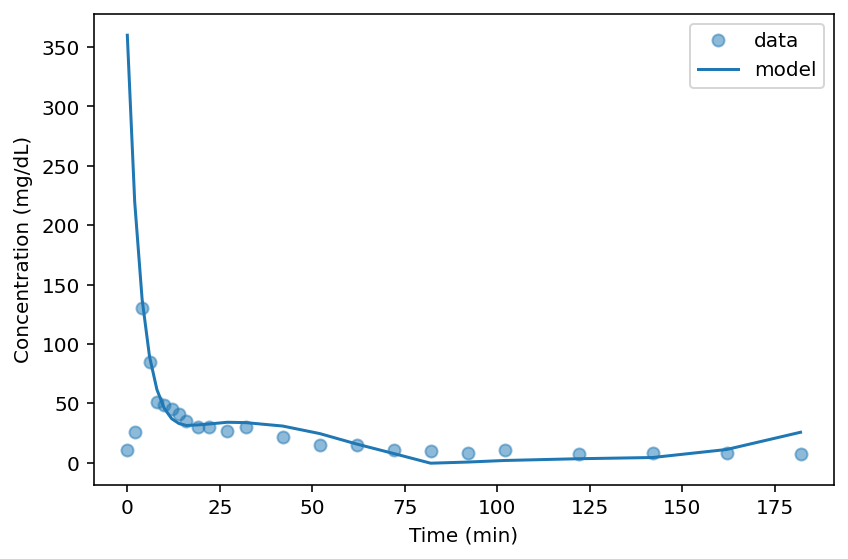

In [60]:
# Solution goes here
data.insulin.plot(style='o', alpha=0.5, label='data')
results.I.plot(style='-', color='C0', label='model')

modsim.decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [61]:
# Solution goes here

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, call `run_solve_ivp`, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did with the glucose model, you might want to drop the first 2-3 elements from the sequence of errors.

In [75]:
# Solution goes here
def error_func(params, data, skip=3):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    skip: number of data to skip at the beginning
    
    returns: array of errors
    """
    #print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = modsim.run_solve_ivp(system, slope_func, t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = (results.I - data.insulin).dropna()
    return errors.iloc[skip:]

In [76]:
# Solution goes here
error_func(params, data)

6       4.524430
8      10.658402
10     -3.246061
12     -7.908701
14     -7.999506
16     -3.582003
19      1.868456
22      2.623064
27      7.112415
32      3.812025
42      8.935032
52      9.596202
62      0.792766
72     -3.207047
82    -10.351188
92     -7.392451
102    -9.062922
122    -3.584825
142    -3.565963
162     3.180971
182    18.705197
dtype: float64

**Exercise:** Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [77]:
# Solution goes here
best_params, fit_details = modsim.leastsq(error_func, params, data)
best_params

array([3.61858033e+02, 2.54409246e-01, 3.57608503e-03, 7.97905177e+01])

In [78]:
# Solution goes here
system_best_params = make_system(best_params, data)

In [79]:
# Solution goes here
results_best_params, details_best_params = modsim.run_solve_ivp(
    system_best_params, slope_func, t_eval=data.index,
)
details_best_params.message

'The solver successfully reached the end of the integration interval.'

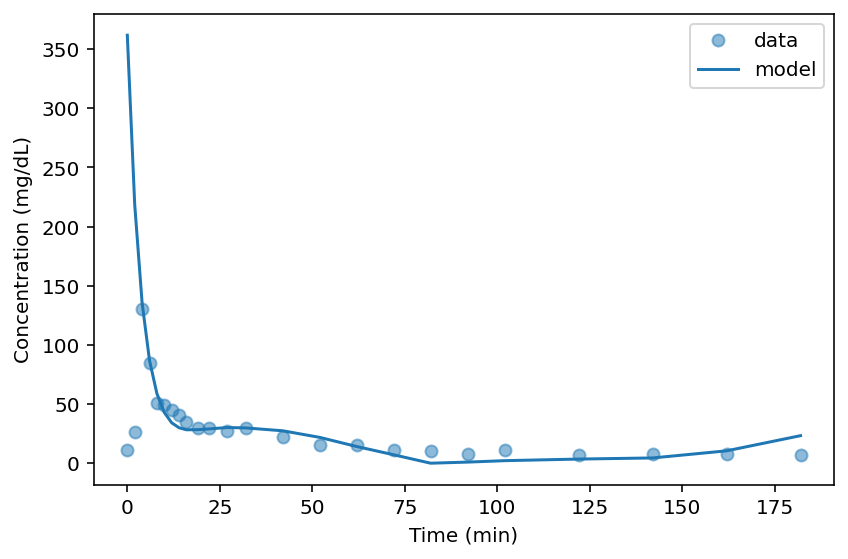

In [80]:
# Solution goes here
data.insulin.plot(style='o', alpha=0.5, label='data')
results_best_params.I.plot(style='-', color='C0', label='model')

modsim.decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [68]:
# Solution goes here
errors_best_params = results_best_params.I - data.insulin
numpy.sum(errors_best_params.iloc[4:]**2)

1023.2552543526836

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 272 mg/dL.  For $G_b$ and $I_b$, use the initial measurements from the data.
For $I_{max}$ is the maximum measurement of insulin concentration.

In [69]:
# Solution goes here
G_0, G_b = 272, data.glucose.iloc[0]
I_b, I_max = data.insulin.iloc[0], data.insulin.max()
phi_1 = (I_max - I_b) / (best_params[1]*(G_0 - G_b))
print(f"phi_1: {phi_1:0.5f}")

phi_1: 2.59861


In [70]:
# Solution goes here
phi_2 = best_params[2]*1e4
print(f"phi_2: {phi_2:0.5f}")

phi_2: 35.76085


According to [Pacini and Bergman](https://www.researchgate.net/publication/13707725_Insulin_sensitivity_and_glucose_effectiveness_Minimal_model_analysis_of_regular_and_insulin-modified_FSIGT), here are the normal ranges for these quantities.

In [71]:
phi_1_interval = 2, 4
phi_1_interval

(2, 4)

In [72]:
phi_2_interval = 20, 35
phi_2_interval

(20, 35)

Do your estimates fall in these ranges?

In [73]:
# Only phi_1. phi_2 exceeds the upper bound by:
(phi_2 - phi_2_interval[1]) / phi_2 * 100

2.1276068905892616

Maybe dropping more data at the beginning of the `leastsq` would improve the results. 